# IR System for dbpedia-entity


### DBpedia Entity Dataset

The DBpedia Entity Dataset is designed to evaluate Information Retrieval (IR) systems focused on retrieving semantic entities. This dataset is based on DBpedia, a resource that extracts structured information from Wikipedia and organizes entities into a semantic network.


In [ ]:
# packets to install
!pip install ir_datasets
!pip install PyStemmer
!pip install ir_measures
!pip install -q python-terrier

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.9/347.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.2/119.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.8 MB/s eta 0:00:00
  Created wheel for warc3-wet-clueweb09: filename=warc3_wet_clueweb09-0.2.5-py3-none-any.whl size=18920 sha256=35d16834cc6b09eaf941cd7900f09a47e5d53212cbf7fad6190c77bc04d0059f
  Stored in directory: /root/.cache/pip/wheels/63/f9/dc/2dd16d3330e327236e4d407941975c42d5159d200cdb7922d8
  Created wheel for cbor: filename=cbor-1.0.0-cp311-cp311-linux_x86_64.whl size=53932 sha256=1f67e755e7cb1d9f39bcc164278934fefc2a5d8ce41d1c1a4996fbbf53977128
  Stored in directory: /root/.cache/pip/wheels/21/6b/45/0c34253b1af07d1d9dc524f6d44d74a6b191c43152e6aaf641
Successfully built warc3-wet-clueweb09 cbor
   ━━━━━━━━

In [ ]:
# Access to drive, need for the index in Pyterrier
import google.colab as google
google.drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#our dataset
import ir_datasets
dataset=ir_datasets.load("beir/dbpedia-entity")
print(next(dataset.docs_iter()))

[INFO] [starting] building docstore
[INFO] [starting] opening zip file
[INFO] If you have a local copy of https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip, you can symlink it here to avoid downloading it again: /root/.ir_datasets/downloads/c2a39eb420a3164af735795df012ac2c
[INFO] [starting] https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip
docs_iter:   0%|                                   | 0/4635922 [00:00<?, ?doc/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip: 0.0%| 0.00/639M [00:00<?, ?B/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip: 0.0%| 32.8k/639M [00:00<1:01:20, 174kB/s]
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip: 0.0%| 98.3k/639M [00:00<35:51, 297kB/s]  
https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/dbpedia-entity.zip: 0.0%| 229k/639M [00:00<21:57, 485kB/s] 
h

BeirTitleUrlDoc(doc_id='<dbpedia:Animalia_(book)>', text="Animalia is an illustrated children's book by Graeme Base. It was originally published in 1986, followed by a tenth anniversary edition in 1996, and a 25th anniversary edition in 2012. Over three million copies have been sold.   A special numbered and signed anniversary edition was also published in 1996, with an embossed gold jacket.", title='Animalia (book)', url='<http://dbpedia.org/resource/Animalia_(book)>')


In [ ]:
# profile function used at the labs
import time
def profile(f):
    def f_timer(*args, **kwargs):
        start = time.time()
        result = f(*args, **kwargs)
        end = time.time()
        ms = (end - start) * 1000
        print(f"{f.__name__} ({ms:.3f} ms)")
        return result
    return f_timer

# Preprocessing

In our code for the preprocessing, we made several optimizations to enhance efficiency and clarity for the creation of the index and the query processing:

- **Preloading stopwords and stemmer**:  
  - Stopwords and the stemmer are **preloaded** at the start of the script and made available as global variables.  
  - This eliminates the need to reload or reprocess them each time a function is called, saving a **significant amount of time**.

- **Precompiled regex patterns**:  
  - We use **precompiled regular expressions** for frequent operations such as:
    - **Normalizing special characters**
    - **Handling punctuation**
    - **Removing multiple white spaces**  
  - This approach prevents regex patterns from being recompiled repeatedly, significantly improving performance.

- **Combining operations**:  
  - Key operations, like tokenization and punctuation removal, are handled in a **single step** using `re.split`.  
  - Similarly, during token iteration, we perform **stopword removal** and **stemming** in one step, avoiding redundancy and speeding up the process.

- **Efficient text cleaning**:  
  - Instead of using slower iterative loops (e.g., `while " " in s`), we utilize **regex-based cleaning** to normalize and remove multiple white spaces in fewer steps.

These choices demonstrate how our preprocessing pipeline is optimized for **speed, scalability, and clarity**.

---

## PyStemmer (Cython)

The decision to use **PyStemmer** is a critical factor that gives us a **significant performance advantage**:

- **Faster than NLTK PorterStemmer**:  
  - PyStemmer is implemented in **Cython**, making it **much faster** than the NLTK PorterStemmer, which is written in pure Python.  
  - **Performance Comparison**:  
    - PyStemmer: Processes **1 million words in less than 2 seconds**.  
    - NLTK PorterStemmer: Takes **12–15 seconds** for the same task.

- **Key Benefits**:  
  - Crucial for **large datasets** or tasks requiring repeated preprocessing (e.g., machine learning, document retrieval).  
  - **Seamless integration**: PyStemmer is easy to use and fits naturally into our pipeline.

In summary, using PyStemmer allows us to build a **faster, more scalable** pipeline, ready for **complex projects** without sacrificing usability.


In [ ]:
import re
import string
import nltk
import Stemmer  # PyStemmer

# Preload resources
nltk.download("stopwords", quiet=True)
STOPWORDS = set(nltk.corpus.stopwords.words("english"))
STEMMER = Stemmer.Stemmer("english")

# Precompile regex patterns
SPECIAL_CHAR_PATTERN = re.compile(r"[‘’´“”–-]")  # Normalize special characters
DOT_PATTERN = re.compile(r"\.(?!(\S[^. ])|\d)")  # Remove dots except in decimals or abbreviations
WHITESPACE_PATTERN = re.compile(r"\s+")

def preprocess(s):

    # 1. Lowercase and normalize special characters
    s = SPECIAL_CHAR_PATTERN.sub("'", s.lower())
    s = DOT_PATTERN.sub("", s)

    # 2. Tokenize and remove punctuation
    tokens = re.split(r"\W+", s)  # Alternative to str.translate for performance

    # 3. Remove stopwords and stem tokens
    tokens = [STEMMER.stemWord(t) for t in tokens if t and t not in STOPWORDS]

    return tokens


# Building Index: Improvements

In the improved version of `build_index`, several enhancements were made to address the limitations of the initial version:
- **Inclusion of titles and text**:  
  - Both the **title** (`doc.title`) and the **textual content** (`doc.text`) of each document are indexed.  
  - This results in a **more comprehensive index**, though it increases size and construction time.

- **Automatic document count**:  
  - The total number of documents is calculated **beforehand** using a dataset function, removing the need for manual counter increments during the loop.

- **Additional statistics**:  
  - A new metric, **average document length**, is returned, providing essential context for ranking algorithms like BM25.

- **Direct use of document IDs**:  
  - Unlike the base version, where `doc.doc_id` was converted to a string, the improved version uses the ID **directly**, reducing unnecessary operations.

---

### Benefits of the Improved Version

- **Richer Index**:  
  - By incorporating titles, the index captures more information, potentially improving search and retrieval performance.

- **Streamlined Workflow**:  
  - Calculating the number of documents upfront simplifies the indexing process and minimizes manual operations.

- **Better Metrics**:  
  - Adding average document length enhances the usefulness of the index for ranking algorithms.  


In [ ]:
from collections import Counter
from tqdm.auto import tqdm

@profile
def build_index(dataset):
    lexicon = {}
    doc_index = []
    inv_d, inv_f = {}, {}
    termid = 0
    total_dl = 0
    total_toks = 0
    for docid, doc in tqdm(enumerate(dataset.docs_iter()), desc='Indexing', total=dataset.docs_count()):
        # combine title and text
        tokens = preprocess(doc.title + doc.text)
        token_tf = Counter(tokens)
        doclen = len(tokens)
        total_dl += doclen
        doc_index.append((doc.doc_id, doclen))
        for token, tf in token_tf.items():
            if token not in lexicon:
                lexicon[token] = [termid, 0, 0]
                inv_d[termid] = []
                inv_f[termid] = []
                termid += 1

            token_id = lexicon[token][0]
            inv_d[token_id].append(docid)
            inv_f[token_id].append(tf)
            lexicon[token][1] += 1
            lexicon[token][2] += tf

    stats = {
        # use only docid, not num_docs
        "num_docs": 1 + docid,
        "num_terms": len(lexicon),
        "num_tokens": total_dl,
        "avg_length": total_dl / (1 + docid)
    }
    return lexicon, {'docids': inv_d, 'freqs': inv_f}, doc_index, stats


In [ ]:
lex, inv, doc, stats = build_index(dataset)

Indexing:   0%|          | 0/4635922 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x78a696061ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tqdm/std.py", line 1147, in __del__
    def __del__(self):

KeyboardInterrupt: 


KeyboardInterrupt: 

# Compression

We implemented compression directly at the **byte level** to ensure **efficiency**, **accuracy**, and adherence to practical standards. Using **Variable Byte Encoding (VBEncode)**, we optimized the representation of numbers, minimizing the space required. Additionally, the use of **delta gaps (dgaps)** for document IDs further improves compression by transforming IDs into smaller, easier-to-compress values.

### Key Features of the Compression System

- **Byte-level operations for precision and efficiency**:  
  - By avoiding strings and unnecessary encoding overhead, we achieve a **compact, portable index** that integrates seamlessly in multi-language or distributed environments.  
  - The use of `bytearray` enhances efficiency for data storage and transmission.

- **Delta gaps for document IDs**:  
  - Document IDs are transformed into **delta gaps**, which are smaller values, making them easier to compress.  
  - This approach ensures **better compression performance** while maintaining functionality.

- **Separation into compression and decompression classes**:  
  - The system is modular, with separate classes for **compressing** and **decompressing** the dictionary.  
  - This allows us to operate exclusively on the dictionary, either in its normal or compressed form, without directly modifying the `inv_index` structure.  
  - The design improves **modularity** and **maintainability**.

---

### Benefits of This Approach

- **Compact and portable index**:  
  - The byte-level encoding ensures the index is lightweight and easily integrable into various systems.  

- **Efficient storage and transmission**:  
  - The use of `bytearray` optimizes the system for both high-compression needs and scenarios requiring ease of frequency management.

- **Modular and maintainable design**:  
  - Separating compression logic into dedicated classes simplifies the codebase and enhances reusability.  


In [ ]:
#!!!for the compression and decompression the RAM offered by colab is not sufficent
import pickle
import numpy as np
from tqdm import tqdm

class Compression:
    def __init__(self, inv):
        self.inv = inv

    @staticmethod
    def VBEncode(n):
        byte = []
        while True:
            byte.append(n % 128)
            if n < 128:
                break
            n //= 128
        byte[0] += 128  # Set the control bit on the first byte
        return byte[::-1]

    @staticmethod
    def VBEncodeList(n_list):
        b = bytearray()
        for n in n_list:
            b.extend(Compression.VBEncode(n))
        return b

    @staticmethod
    def VBDecode(byte_array):
        n_list = []
        n = 0
        for b in byte_array:
            if b < 128:
                n = 128 * n + b
            else:
                n = 128 * n + (b - 128)
                n_list.append(n)
                n = 0
        return n_list

    @staticmethod
    def dgaps(n_list):
        return [n_list[0]] + list(np.diff(n_list))

    def vb_compress_docids(self, doc_ids):
        # Apply delta gaps to docids and then encode
        return Compression.VBEncodeList(Compression.dgaps(doc_ids))

    def compress_inverted_index(self):
        compressed_inv = {'docids': {}, 'freqs': {}}
        for term_id, doc_ids in tqdm(self.inv['docids'].items(), desc="Compressing docids"):
            compressed_inv['docids'][term_id] = self.vb_compress_docids(doc_ids)  # Compress docids with delta gaps
            compressed_inv['freqs'][term_id] = self.inv['freqs'][term_id]  # Leave freqs unchanged
        return compressed_inv

    def vb_decompress_docids(self, byte_array):
        # Decode and then reconstruct original docids using cumulative sum
        dgaps = Compression.VBDecode(byte_array)
        return list(np.cumsum(dgaps))

    def decompress_inverted_index(self, compressed_inv):
        decompressed_inv = {'docids': {}, 'freqs': {}}
        for term_id, encoded_docids in tqdm(compressed_inv['docids'].items(), desc="Decompressing docids"):
            decompressed_inv['docids'][term_id] = self.vb_decompress_docids(encoded_docids)   # Decompress docids
            decompressed_inv['freqs'][term_id] = compressed_inv['freqs'][term_id]  # Retrieve freqs unchanged
        return decompressed_inv


In [ ]:
compression=Compression(inv)
compressed_inv = compression.compress_inverted_index()

Compressing docids: 100%|██████████| 5520712/5520712 [01:57<00:00, 47070.88it/s] 


In [ ]:
# Save the compressed index
import pickle
import humanize
import os

with open('comp_dict.pickle', 'wb') as f:
    pickle.dump((compressed_inv), f)

print(f'The compressed inverted index requires {humanize.naturalsize(os.path.getsize("comp_dict.pickle"))} bytes (all included)')

The compressed inverted index requires 565.6 MB bytes (all included)


In [ ]:

decompression=Compression(compressed_inv)
decomp_inv=decompression.decompress_inverted_index(compressed_inv)

Decompressing docids: 100%|██████████| 5520712/5520712 [01:06<00:00, 82972.54it/s]


# Inverted Index

In our approach, we decided to structure the inverted index in a more modular way compared to the code seen in class, in order to improve the class structure. One of the key decisions was to separate the management of the posting lists from the main index structure. This allows us to keep the code cleaner and more scalable, simplifying the addition of new functionalities such as other ranking methods or future optimizations.

Another significant difference lies in the score calculation. In the professor's code, the score is based solely on the relative frequency of the term compared to the document length, a simple but limited method. We, on the other hand, decided to integrate advanced ranking models such as **TF-IDF** and **BM25**. To support these methods, we added global statistics like **IDF** and the **average document length**, calculating them once to avoid recalculations during queries. This allows us to provide more accurate results and adapt the system to more complex scenarios.

Additionally, another new feature is the passing of new stats as parameters to facilitate score calculations (since they are more complex and require more specific measures).


### TF-IDF Formula

The TF-IDF score for a term $ t $ in a document $ d $ is calculated as:

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \cdot \text{IDF}(t)
$$

Where:

- **Term Frequency (TF):**

$$
\text{TF}(t, d) = f_{t,d}
$$

- **Inverse Document Frequency (IDF):**

$$
\text{IDF}(t) = \log \left( \frac{N}{\text{df}(t) + 1} \right)
$$

Here:
- $ f_{t,d} $: frequency of term $ t $ in document $ d $.
- $ len(d) $: length of document $ d $ (total number of terms).
- $ N $: total number of documents.
- $ df(t) $: number of documents containing the term $ t $.


### BM25 Formula

The BM25 score for a term $ t $ in a document $ d $ is calculated as:

$$
RSV_{BM25}(q, d) = \sum_{t \in q} \text{IDF}(t) \cdot \frac{\text{TF}(t, d) \cdot (k_1 + 1)}{\text{TF}(t, d) + k_1 \cdot \left( (1 - b) + b \cdot \frac{\text{len}(d)}{\text{avgdl}} \right)}
$$

Where:

- **Term Frequency (TF):**

$$
\text{TF}(t, d) = f_{t,d}
$$

- **Inverse Document Frequency (IDF):**

$$
\text{IDF}(t) = \log \left( \frac{N - \text{df}(t) + 0.5}{\text{df}(t) + 0.5} + 1 \right)
$$

- **Parameters:**


In [ ]:
import pickle
import humanize
import os
with open('your path', 'wb') as f:
    pickle.dump((lex, inv, doc, stats), f)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Consegna_Progetti_MIRCV/IR/IR_Indexes/datasets_and_index/index.pickle'

In [ ]:
# Use directly the original inverted index
import pickle
import humanize
import os
with open('your path', 'rb') as f:
    lex,inv,doc,stats=pickle.load(f)

print(f'The inverted index requires {humanize.naturalsize(os.path.getsize("your path"))} bytes (all included)')

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/Shareddrives/Consegna_Progetti_MIRCV/IR/IR_Indexes/datasets_and_index/index.pickle'

In [ ]:
import math

# Constants for BM25 scoring
k1 = 1.2
b = 0.75

class InvertedIndex:

    class PostingListIterator:
        def __init__(self, docids, freqs, doc, num_docs, avg_doc_len, method="bm25"):
            self.docids = docids
            self.freqs = freqs
            self.pos = 0  # Current position in the posting list
            self.doc = doc
            self.num_docs = num_docs
            self.avg_doc_len = avg_doc_len
            self.method = method

            # Precomputing IDF (constant for each term)
            self.df = len(docids)
            if method == "bm25":
                self.idf = math.log((num_docs - self.df + 0.5) / (self.df + 0.5) + 1) #BM1
            elif method == "TFIDF":
                self.idf = math.log((num_docs / (self.df + 1)) + 1)

        def docid(self):
            # Returns the current document ID or infinity if the list is exhausted
            if self.is_end_list():
                return math.inf
            return self.docids[self.pos]

        def score(self):
            # Computes the score of the current document based on the chosen method
            if self.is_end_list():
                return math.inf

            tf = self.freqs[self.pos]  # Term frequency in the current document
            doc_length = self.doc[self.docid()][1]  # Length of the current document

            if self.method == "bm25":
                # BM25 scoring formula
                tf_component = (tf * (k1 + 1)) / (tf + k1 * (1 - b + b * (doc_length / self.avg_doc_len)))
                score = self.idf * tf_component
            elif self.method == "TFIDF":
                # TF-IDF scoring formula
                score = (1 + math.log(tf)) * self.idf if tf > 0 else 0
            return score

        def next(self, target=None):
            # Moves to the next position or jumps to the target document ID if specified
            if not target:
                if not self.is_end_list():
                    self.pos += 1
            else:
                if target > self.docid():
                    try:
                        self.pos = self.docids.index(target, self.pos)
                    except ValueError:
                        self.pos = len(self.docids)

        def is_end_list(self):
            # Checks if the end of the posting list has been reached
            return self.pos == len(self.docids)

        def len(self):
            # Returns the length of the posting list
            return len(self.docids)

    def __init__(self, lex, inv, doc, stats, method="bm25"):
        self.lexicon = lex  # Lexicon containing term mappings
        self.inv = inv  # Inverted index with document IDs and term frequencies
        self.doc = doc  # Document metadata (e.g., lengths)
        self.stats = stats  # Corpus statistics (e.g., total docs, tokens)
        self.method = method  # Scoring method (BM25 or TF-IDF)

    def num_docs(self):
        # Returns the total number of documents in the corpus
        return self.stats['num_docs']

    def get_posting(self, termid):
        # Retrieves the posting list iterator for a given term ID
        return InvertedIndex.PostingListIterator(
            self.inv['docids'][termid],
            self.inv['freqs'][termid],
            self.doc,
            self.stats["num_docs"],
            self.stats["num_tokens"] / self.stats["num_docs"]
        )

    def get_termids(self, tokens):
        # Maps a list of tokens to their corresponding term IDs
        return [self.lexicon[token][0] for token in tokens if token in self.lexicon]

    def get_postings(self, termids):
        # Retrieves posting list iterators for a list of term IDs
        return [self.get_posting(termid) for termid in termids]


In [ ]:
#if you use the original index
inv_index = InvertedIndex(lex, inv, doc, stats)
inv_index.num_docs()

4635922

In [ ]:
#if you use the decompressed index
inv_index=InvertedIndex(lex,decomp_inv,doc,stats)
inv_index.num_docs()

# Query Processing

Our dataset, DBpedia, is a collection of documents summarizing Wikipedia descriptions in a few lines. The purpose of our IR system is to find the top k most relevant documents based on the user's query. For this reason, in the Query Processing phase, we directly approached a rank retrieval system with disjunctive queries. In this section, we will explore whether it's possible to modify the **daat** and **taat** approaches discussed in class to improve the efficiency of our IR system, and then evaluate which of these two approaches proves to be more efficient.


In [ ]:
import ir_datasets
dataset=ir_datasets.load("beir/dbpedia-entity")
#initial test  query
query_test=next(dataset.queries_iter())

[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


For this project, we will rely on the **TopQueue** class implemented in the lab, which internally uses a heap structure to store the top k results in order of their score. It will be the object returned by the query processing. The main modifications include the creation of an internal sorting function within the class to order the heap based on the score, and the addition of a **query_id** to the elements inside the heap. This **query_id** will be used during the evaluation of the effectiveness of our IR system.


In [ ]:
import heapq

class TopQueue:
    def __init__(self, k=10, threshold=0.0):
        self.queue = []
        self.k = k  # Maximum number of items in the priority queue
        self.threshold = threshold  # Minimum score required for insertion

    def size(self):
        return len(self.queue)

    def would_enter(self, score):
        # Checks if a score is higher than the current threshold
        return score > self.threshold

    def clear(self, new_threshold=None):
        # Clears the queue and optionally sets a new threshold
        self.queue = []
        if new_threshold:
            self.threshold = new_threshold

    def __repr__(self):
        # Returns a string representation of the queue
        return f'<{self.size()} items, th={self.threshold} {self.queue}>'

    def insert(self, score, query_id, docid):
        # Inserts an item into the priority queue if it meets the threshold
        if not self.would_enter(score):
            return False  # The score is too low to be added to the heap

        # Adds the query ID along with the score and document ID
        if self.size() < self.k:
            heapq.heappush(self.queue, (score, query_id, docid))
        else:
            heapq.heapreplace(self.queue, (score, query_id, docid))

        # Updates the threshold only if the queue contains at least `k` elements
        if self.size() >= self.k:
            self.threshold = self.queue[0][0]

        return True

    def sort_descending(self):
        # Sorts the queue by score in descending order
        self.queue = sorted(self.queue, key=lambda x: x[0], reverse=True)
        return self.queue


# NEW_DAAT: Optimization of the Document-At-A-Time Algorithm

## Introduction
The **NEW_DAAT** method represents an optimization over the **DAAT** approach discussed in class. Specifically, we tried to replace the use of the `mindocid` function with a heap structure to find the minimum `doc_id` while scanning the posting lists in parallel.

### NEW_DAAT Improvements
1. **Use of a heap**:
   - Finds the minimum `docid` in constant time $O(1)$ instead of scanning all lists $O(p)$.
   - Maintains a heap (priority queue) to manage active `docid`s.
2. **Smart processing**:
   - Advances pointers only for relevant lists.
   - Ignores exhausted postings.
3. **Overall efficiency**:
   - Reduces repeated comparisons and improves performance on large datasets.


In [ ]:
import heapq
import math

def min_docid_heap(postings_heap):
    # Use a heap structure to find the min docid -> the top of the heap
    while postings_heap:
        score, index, posting = postings_heap[0]
        if not posting.is_end_list():  # Check if the posting list is not exhausted
            return posting.docid()
        heapq.heappop(postings_heap)  # Remove the top of the heap if the posting is at the end
    return math.inf  # Return infinity if no valid document IDs remain

def new_daat(query_id, postings, k=10):
    top = TopQueue(k)
    postings_heap = []

    # Initialize heap with the first document id for each posting
    for i, posting in enumerate(postings):
        if not posting.is_end_list():
            heapq.heappush(postings_heap, (posting.docid(), i, posting))

    current_docid = min_docid_heap(postings_heap)  # Get the smallest document ID from the heap

    while current_docid != math.inf:
        score = 0
        next_postings_heap = []

        while postings_heap:  # Process postings with the current document ID
            docid, index, posting = heapq.heappop(postings_heap)
            if posting.docid() == current_docid:
                score += posting.score()  # Accumulate score for the current document ID
                posting.next()  # Advance to the next posting
                if not posting.is_end_list():  # Re-add posting to the heap if not exhausted
                    heapq.heappush(next_postings_heap, (posting.docid(), index, posting))
            else:
                heapq.heappush(next_postings_heap, (docid, index, posting))  # Keep postings for other document IDs

        # Insert the score of the current document ID into the result queue
        top.insert(score, query_id, current_docid)

        # Update the heap for the next iteration
        postings_heap = next_postings_heap

        # Get the next smallest document ID from the updated heap
        current_docid = min_docid_heap(postings_heap)

    return top.sort_descending()  # Return results sorted in descending order
@profile
def query_process_new_daat(query, index):
    qtokens = set(preprocess(query.text))  # Preprocess query to extract unique tokens
    qtermids = index.get_termids(qtokens)  # Get term IDs for query tokens
    postings = index.get_postings(qtermids)  # Retrieve postings for term IDs
    return new_daat(query.query_id, postings)


In [ ]:
import math
def min_docid(postings):
    min_docid = math.inf
    for p in postings:
        if not p.is_end_list():
            min_docid = min(p.docid(), min_docid)
    return min_docid
def daat(postings, k=10):
    top = TopQueue(k)
    current_docid = min_docid(postings)
    while current_docid != math.inf:
        score = 0
        next_docid = math.inf
        for posting in postings:
            if posting.docid() == current_docid:
                score += posting.score()
                posting.next()
            if not posting.is_end_list() and posting.docid() < next_docid:
                next_docid = posting.docid()
        top.insert(score,0,current_docid)
        current_docid = next_docid

    return sorted(top.queue, reverse=True)
@profile
def query_process_daat(query, index):
    qtokens = set(preprocess(query.text))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return daat(postings)

Let's compare the results to see if we notice an improvement in time with the new changes.


In [ ]:
new_res=query_process_new_daat(query_test,inv_index)
res=query_process_daat(query_test,inv_index)
print(res)
print(new_res)

query_process_new_daat (543.091 ms)
query_process_daat (556.537 ms)
[(21.59147230015924, 0, 367754), (18.795246398976357, 0, 2091522), (16.969878640694485, 0, 2007656), (16.46567790214739, 0, 2723675), (16.442701311335128, 0, 1225602), (16.39756146534163, 0, 2582919), (16.34353693741285, 0, 517969), (16.22198800368843, 0, 2429746), (16.16937594276275, 0, 386825), (16.115939351468775, 0, 3561287)]
[(21.59147230015924, 'INEX_LD-20120112', 367754), (18.795246398976357, 'INEX_LD-20120112', 2091522), (16.969878640694485, 'INEX_LD-20120112', 2007656), (16.46567790214739, 'INEX_LD-20120112', 2723675), (16.442701311335128, 'INEX_LD-20120112', 1225602), (16.39756146534163, 'INEX_LD-20120112', 2582919), (16.34353693741285, 'INEX_LD-20120112', 517969), (16.22198800368843, 'INEX_LD-20120112', 2429746), (16.16937594276275, 'INEX_LD-20120112', 386825), (16.115939351468775, 'INEX_LD-20120112', 3561287)]


# Optimization of the Taat Function

New Taat is very similar to Taat, with the only confirmed changes being:

* Directly checking within the taat function if a document can enter the top-k, avoiding the insert and various class processes with the `would-enter` function.
* Sorting the heap using the internal `sort_descending` function of the **TopQueue** class.


In [ ]:
from collections import defaultdict, Counter
import heapq
import math

def new_taat(query_id, postings,doc, k=10):
    # Step 1: Aggregate scores for each document in a dictionary
    doc_scores = defaultdict(float)
    for posting in postings:
        current_docid = posting.docid()
        while current_docid != math.inf:
            doc_scores[current_docid] += posting.score()
            posting.next()
            current_docid = posting.docid()

    # Step 2: Use TopQueue to maintain top-k scoring documents efficiently
    top = TopQueue(k)
    for docid, score in doc_scores.items():
        # Only insert if score is high enough to enter top-k
        if top.would_enter(score):
            top.insert(score, query_id, doc[docid][0])

    # Step 3: Return sorted results from TopQueue
    return top.sort_descending()
@profile
def query_process_new_taat(query, index):
    qtokens = set(preprocess(query.text))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return new_taat(query.query_id, postings,index.doc)

In [ ]:
from collections import defaultdict

def taat(postings, k=10):
    A = defaultdict(float)
    for posting in postings:
        current_docid = posting.docid()
        while current_docid != math.inf:
            A[current_docid] += posting.score()
            posting.next()
            current_docid = posting.docid()
    top = TopQueue(k)
    for docid, score in A.items():
        top.insert(score,0,docid)
    return sorted(top.queue, reverse=True)
@profile
def query_process_taat(query, index):
    qtokens = set(preprocess(query.text))
    qtermids = index.get_termids(qtokens)
    postings = index.get_postings(qtermids)
    return taat(postings)

We also observe, although less clearly than with the DAAT function, an improvement in timing with the new changes.


In [ ]:
res_new_taat=query_process_new_taat(query_test,inv_index)
res_taat=query_process_taat(query_test,inv_index)
print(res_taat)
print(res_new_taat)

query_process_new_taat (309.473 ms)
query_process_taat (325.153 ms)
[(21.59147230015924, 0, 367754), (18.795246398976357, 0, 2091522), (16.969878640694485, 0, 2007656), (16.46567790214739, 0, 2723675), (16.442701311335128, 0, 1225602), (16.39756146534163, 0, 2582919), (16.34353693741285, 0, 517969), (16.22198800368843, 0, 2429746), (16.16937594276275, 0, 386825), (16.115939351468775, 0, 3561287)]
[(21.59147230015924, 'INEX_LD-20120112', '<dbpedia:Opinion>'), (18.795246398976357, 'INEX_LD-20120112', '<dbpedia:Cartridge_Trap>'), (16.969878640694485, 'INEX_LD-20120112', '<dbpedia:Terminology_of_the_Vietnam_War>'), (16.46567790214739, 'INEX_LD-20120112', '<dbpedia:Leaders_of_the_Vietnam_War>'), (16.442701311335128, 'INEX_LD-20120112', '<dbpedia:List_of_songs_about_the_Vietnam_War>'), (16.39756146534163, 'INEX_LD-20120112', '<dbpedia:List_of_Vietnam_War_games>'), (16.34353693741285, 'INEX_LD-20120112', '<dbpedia:Awards_and_decorations_of_the_Vietnam_War>'), (16.22198800368843, 'INEX_LD-2012

# Efficency evaluation

# **Query Processor Efficiency Evaluation: DAAT vs. TAAT**

In this study, we compare the performance of two query processing approaches: **DAAT** (Document-at-a-time) and **TAAT** (Term-at-a-time). The evaluation focuses on three key metrics: **throughput**, **average query time**, and **execution time variance**. We also perform a statistical test to determine if the differences between the two approaches are significant.

## **Metric Definitions**

### **1. Throughput**
Throughput measures the amount of work completed per unit of time. In this case, it refers to the number of queries processed per second, calculated as:

$$
\text{Throughput} = \frac{k_{\text{sample}}}{\text{Total time to process all queries}}
$$

where:
- $ k_{\text{sample}} $ is the number of queries sampled in each iteration,
- **Total time to process all queries** is the sum of the execution times for all queries.

### **2. Average Query Time**
The average query time is the mean of the execution times for all sampled queries. It is calculated as:

$$
\text{Average Query Time} = \frac{1}{k_{\text{sample}}} \sum_{i=1}^{k_{\text{sample}}} \text{Query Time}_i
$$

where:
- $ \text{Query Time}_i $ is the time taken to process query \( i \).

### **3. Execution Time Variance**
Execution time variance measures the dispersion of query execution times from the average. It is calculated as:

$$
\text{Variance} = \frac{1}{k_{\text{sample}}} \sum_{i=1}^{k_{\text{sample}}} \left( \text{Query Time}_i - \text{Average Time} \right)^2
$$

where:
- $\text{Query Time}_i $ is the execution time of query \( i \),
- $ \text{Average Time} $ is the mean execution time.

## **Evaluation Process**

The evaluation function `evaluate_query_processor` performs the following steps:

1. **Query Sampling**: A random subset of $k_{\text{sample}}$ queries is selected from the available query set.
2. **Execution Time Measurement**: For each sampled query, execution time is measured and the average query time is calculated.
3. **Metric Calculation**: For each iteration, the following metrics are computed:
   - **Throughput**,
   - **Average Query Time**,
   - **Time Variance**.
4. **Result Updates**: Results are stored in a dictionary containing throughput, average time, and variance for each iteration.

## **Statistical Comparison**

To determine if there are significant differences in throughput between DAAT and TAAT, we perform a **t-test** on the throughput of both implementations:

$$
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$

where:
- $ \bar{X}_1 $ and $ \bar{X}_2 $ are the average throughputs for DAAT and TAAT,
- $ s_1^2 $ and $ s_2^2 $ are the variances of the throughputs for DAAT and TAAT,
- $n_1$ and $n_2$ are the number of observations for DAAT and TAAT.

The t-test result (statistic  t  and p-value) helps us determine if the difference between the two approaches is statistically significant. If the p-value is below a predefined threshold (e.g., \( p < 0.05 \)), we can reject the null hypothesis that both groups have the same throughput.


467 10


Processing iterations: 100%|██████████| 10/10 [03:56<00:00, 23.63s/iter]


DAAT - Average Throughput: 0.85, Variance: 0.23
TAAT - Average Throughput: 1.47, Variance: 0.54
DAAT - Average Query Time: 1.54077 sec
TAAT - Average Query Time: 0.82207 sec
T-test (Throughput): t=-2.13, p=4.74e-02


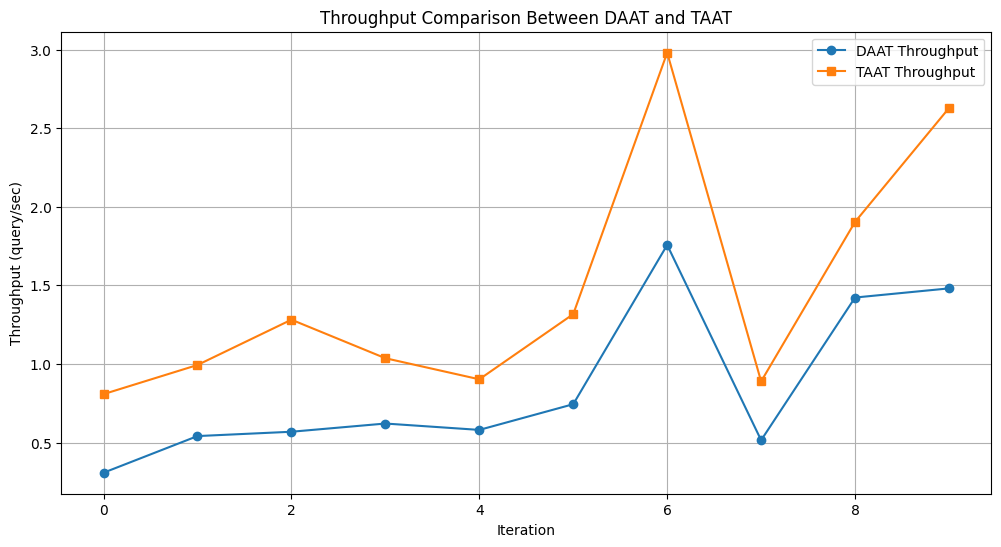

In [ ]:
import random
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from tqdm import tqdm  # Import tqdm for progress bar

def evaluate_query_processor(daat_func, taat_func, queries, index, n_iter=10, k_sample=10):
    results = {
        "throughputs_daat": [],
        "throughputs_taat": [],
        "mean_times_daat": [],
        "mean_times_taat": [],
        "variances_daat": [],
        "variances_taat": []
    }

    print(len(queries), k_sample)
    with tqdm(total=n_iter, desc="Processing iterations", unit="iter") as pbar:
        for _ in range(n_iter):
            # Sample the same set of queries for both functions
            sampled_queries = random.sample(queries, k_sample)  # Convert iterator to list if necessary
            query_times_daat = []
            query_times_taat = []

            for query in sampled_queries:
                # Process DAAT
                start_time = time.time()
                daat_func(query, index)
                elapsed_time = time.time() - start_time
                query_times_daat.append(elapsed_time)

                # Process TAAT
                start_time = time.time()
                taat_func(query, index)
                elapsed_time = time.time() - start_time
                query_times_taat.append(elapsed_time)

            # Calculate metrics for DAAT
            mean_time_daat = np.mean(query_times_daat)
            variance_time_daat = np.var(query_times_daat)
            throughput_daat = k_sample / sum(query_times_daat)

            # Calculate metrics for TAAT
            mean_time_taat = np.mean(query_times_taat)
            variance_time_taat = np.var(query_times_taat)
            throughput_taat = k_sample / sum(query_times_taat)

            # Save the results
            results["throughputs_daat"].append(throughput_daat)
            results["throughputs_taat"].append(throughput_taat)
            results["mean_times_daat"].append(mean_time_daat)
            results["mean_times_taat"].append(mean_time_taat)
            results["variances_daat"].append(variance_time_daat)
            results["variances_taat"].append(variance_time_taat)

            pbar.update(1)

    return results

# Simulate a set of queries and an index (to be implemented)
queries = list(dataset.queries_iter())  # List or iterator of queries

# Compare performances
n_iter = 10
k_sample = 10

# Remove decorators from the functions to be executed
results = evaluate_query_processor(query_process_new_daat, query_process_new_taat, queries, inv_index, n_iter, k_sample)

# Descriptive statistics
mean_daat_throughput = np.mean(results["throughputs_daat"])
mean_taat_throughput = np.mean(results["throughputs_taat"])
var_daat_throughput = np.var(results["throughputs_daat"])
var_taat_throughput = np.var(results["throughputs_taat"])

print(f"DAAT - Average Throughput: {mean_daat_throughput:.2f}, Variance: {var_daat_throughput:.2f}")
print(f"TAAT - Average Throughput: {mean_taat_throughput:.2f}, Variance: {var_taat_throughput:.2f}")

mean_daat_query_time = np.mean(results["mean_times_daat"])
mean_taat_query_time = np.mean(results["mean_times_taat"])
print(f"DAAT - Average Query Time: {mean_daat_query_time:.5f} sec")
print(f"TAAT - Average Query Time: {mean_taat_query_time:.5f} sec")

# T-test
t_stat, p_value = ttest_ind(results["throughputs_daat"], results["throughputs_taat"])
print(f"T-test (Throughput): t={t_stat:.2f}, p={p_value:.2e}")

# Plots
plt.figure(figsize=(12, 6))
plt.plot(results["throughputs_daat"], label="DAAT Throughput", marker='o')
plt.plot(results["throughputs_taat"], label="TAAT Throughput", marker='s')
plt.xlabel("Iteration")
plt.ylabel("Throughput (query/sec)")
plt.title("Throughput Comparison Between DAAT and TAAT")
plt.legend()
plt.grid()
plt.show()


As reported by this evaluation, the **TAAT** method, for execution with a local runtime and a moderately sized collection (4.6 million documents), proves to be significantly more efficient than **DAAT**, with an average throughput of **1.31 queries per second**.


# Effectiveness evaluation

At this point, during the evaluation of the effectiveness of our IR model, we use the metrics available in **IR_measures**, create a list of **ScoreDoc** objects comparable with the **qrels** provided by **BEIR**, and verify the results.


In [ ]:
from ir_measures import ScoredDoc
import ir_measures

In [ ]:
import ir_datasets
dataset_test = ir_datasets.load("beir/dbpedia-entity/test")
next(dataset_test.qrels_iter())

[INFO] [starting] opening zip file
[INFO] [finished] opening zip file s]


TrecQrel(query_id='INEX_LD-2009022', doc_id='<dbpedia:Afghan_cuisine>', relevance=0, iteration='0')

In [ ]:
results=[]
# creation of the istance ScoreDoc for the ir_measures
def CreateScoreDoc(heap):
        for elem in heap:
            scoredoc=ScoredDoc(elem[1], str(elem[2]),elem[0])
            results.append(scoredoc)

In [ ]:
from ir_measures import Qrel
# conversion from  qrel ir_dataset to ir_measures Qrel
dataset_qrels=list(dataset_test.qrels_iter())
qrels=[]
for dq in dataset_qrels:
    qrels.append(Qrel(dq.query_id,dq.doc_id,dq.relevance))

In [ ]:
# Creation of the results for effectivenss
def query_processing_effectiveness(queries_iter):
    for q in tqdm(dataset.queries_iter(), desc="Querying Effectiveness",total=dataset.queries_count()):
        query = preprocess(q.text)
        termids = inv_index.get_termids(query)
        postings = inv_index.get_postings(termids)
        res = new_taat(q.query_id,postings,inv_index.doc)
        CreateScoreDoc(res)

In [ ]:
query_processing_effectiveness(dataset.queries_iter())

Querying Effectiveness: 100%|██████████| 467/467 [06:37<00:00,  1.18it/s]


## Evaluator Class for Comparing Results with Qrels

We have implemented the `IRSystemEvaluator` class to facilitate the evaluation of retrieval results by comparing them to the qrels using the `ir_measures` library. The results are transformed into a `scoredoc` format, ensuring compatibility with the library's evaluation methods. In my dataset (DBpedia-entity), the qrels are graded with relevance levels of 0, 1, and 2, which reflect varying degrees of importance for the documents. Given this structure, it is essential to focus on metrics that account for **graded relevance** effectively.

The primary measures used are:
- **nDCG (Normalized Discounted Cumulative Gain)**: This metric is ideal for graded qrels as it rewards higher relevance levels while penalizing lower-ranked relevant documents.
- **MAP (Mean Average Precision)**: A robust measure for overall ranking quality, aggregating precision across all positions.
- **Precision@k (P@k)**: Useful for assessing the proportion of relevant documents among the top `k` results, especially valuable for evaluating user satisfaction with the highest-ranked results.
- **Recall@k**: Measures how much of the total relevant information is retrieved in the top `k` documents, providing insights into the system's coverage.

These metrics are preferred because they inherently handle graded relevance better than binary metrics like F1-score or accuracy, making them more suited for evaluating a dataset with relevance levels like DBpedia-entity. Other metrics, such as rank correlation measures, could complement the evaluation but are not as critical for this context.


In [ ]:
import ir_measures
from ir_measures import nDCG, AP, P, Recall,MAP

class IRSystemEvaluator:
    def __init__(self, qrels, results):
        self.qrels = qrels
        self.results = results

    def evaluate(self, metrics=[nDCG@10, MAP, P@5, Recall@10]):
        scores = {}
        for metric in metrics:
            score = ir_measures.calc_aggregate([metric], self.qrels, self.results)
            scores[metric] = score
        return scores

    def detailed_ndcg(self, k=10):
        """
        Calculates the nDCG@k metric, suitable for qrels with multi-level relevance.

        :param k: Cutoff level for nDCG
        :return: nDCG@k
        """
        return ir_measures.calc_aggregate([nDCG@k], self.qrels, self.results)

    def precision_at_k(self, k=10):
        """
        Calculates Precision@k, useful for evaluating precision in the top positions.

        :param k: Cutoff level for precision
        :return: Precision@k
        """
        return ir_measures.calc_aggregate([P @ k], self.qrels, self.results)

    def recall_at_k(self, k=10):
        """
        Calculates Recall@k, useful for seeing how much the system retrieves from the top k documents.

        :param k: Cutoff level for recall
        :return: Recall@k
        """
        return ir_measures.calc_aggregate([Recall @ k], self.qrels, self.results)

# Example usage of the class

evaluator = IRSystemEvaluator(qrels, results)
# Precision@10
precision_10 = evaluator.precision_at_k(k=10)
print("Precision@10:", precision_10)

# Recall@10
recall_10 = evaluator.recall_at_k(k=10)
print("Recall@10:", recall_10)

# Perform the general evaluation
scores = evaluator.evaluate()
print("Scores:", scores)


Precision@10: {P@10: 0.2650000000000001}
Recall@10: {R@10: 0.1803579622827695}
Scores: {nDCG@10: {nDCG@10: 0.2928845533039625}, AP: {AP: 0.13216855168144112}, P@5: {P@5: 0.32300000000000045}, R@10: {R@10: 0.1803579622827695}}


# Comparison with pyterrier experiment

In this section, we observe the results obtained from PyTerrier to verify if the results align with already developed IR systems. However, the dpedia-entity index is not provided by PyTerrier, so we also included the code that allowed us to convert the collection, queries, qrels into CSV files and to create the PyTerrier inverted index.


In [ ]:
!pip install -q python-terrier

In [ ]:
import pyterrier as pt
pt.init()

terrier-assemblies 5.10 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.8 jar not found, downloading to /root/.pyterrier...
Done


Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.10 (build: craigm 2024-08-22 17:33), helper_version=0.0.8]
<ipython-input-24-87c43134d443>:2: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
java is now started automatically with default settings. To force initialisation early, run:
pt.java.init() # optional, forces java initialisation
  pt.init()



```
import google.colab
import pandas as pd
google.colab.drive.mount('/content/drive/')
dbpedia=pt.datasets.get_dataset("irds:beir/dbpedia-entity/test")
BM25 = pt.terrier.Retriever(dbpedia.get_index(), wmodel="BM25")

# Load dataset.csv into a DataFrame
dataset_df = pd.read_csv("/content/drive/Shareddrives/Multimedia /dataset.csv")

# Load queries.csv into a DataFrame
queries_df = pd.read_csv("/content/drive/Shareddrives/Multimedia /queries.csv")
qrels_df = pd.read_csv("/content/drive/Shareddrives/Multimedia /qrels.csv")

# Display the first few rows of each DataFrame to confirm successful loading
print("Dataset CSV:")
print(dataset_df.head())

print("\nQueries CSV:")
print(queries_df.head())
```



In [ ]:
import pandas as pd
import re
queries_df = pd.read_csv("your path")
queries_df['text'] = queries_df['text'].apply(lambda x: re.sub(r"[^a-zA-Z0-9\s]", "", x))
qrels_df = pd.read_csv("your path")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
index = pt.IndexFactory.of("your path")
print(index.getCollectionStatistics())
queries_df.rename(columns={'text': 'query'}, inplace=True)
print(queries_df.columns)
br = pt.terrier.Retriever(index, wmodel="BM25")

09:28:43.578 [main] WARN org.terrier.structures.BaseCompressingMetaIndex -- File /content/drive/Shareddrives/Consegna_Progetti_MIRCV/IR/IR_Indexes/index_3docs/data.meta-0.fsomapfile containing reverse meta mapping for keydocno is missing. Reverse lookups for this key will be disabled
Number of documents: 4635922
Number of terms: 4523524
Number of postings: 118357457
Number of fields: 0
Number of tokens: 145436128
Field names: []
Positions:   false

Index(['qid', 'query'], dtype='object')


In [ ]:
results = pt.Experiment(
    [br],             # list of retrieval models
    queries_df,                 # queries DataFrame
    qrels_df,                   # relevance judgments DataFrame
    eval_metrics=["map", "ndcg_cut_10", "recip_rank", "P.10"],  # metrics to evaluate
    names=["BM25"]           # optional name for the retriever
)

# Display the experiment results
print(results)

   name       map  ndcg_cut_10  recip_rank    P.10
0  BM25  0.204483     0.280363    0.554026  0.2535


We observe how the metrics are very similar between our IR system and that one built in Pyterrier.


The Search Engine



In [ ]:
doc_lookup = {doc.doc_id: doc for doc in dataset.docs_iter()}

In [ ]:
class SearchEngine:
    def __init__(self, index, doc_lookup):
        self.index = index
        self.doc_lookup = doc_lookup  # Passa la lookup come parametro

    def search(self):
        user_query = input("Enter your search query: ")
        tokens = set(preprocess(user_query))  # Pre-elabora la query
        term_ids = self.index.get_termids(tokens)  # Ottieni gli ID dei termini
        postings = self.index.get_postings(term_ids)  # Ottieni i postings per gli ID dei termini

        results = new_taat(user_query, postings, self.index.doc)  # Calcolo del ranking

        print("Top results:")
        for score, _,doc_id in results:
            print(doc_id)
            # Recupera i dati del documento dalla lookup
            doc_data = self.doc_lookup.get(doc_id)
            if doc_data:  # Verifica che il documento esista
                print(f"{doc_data.title} (Score: {score:.2f})")
                print(f"Link: {doc_data.url}\n")
            else:
                print(f"Document with ID {doc_id} not found in the dataset.")


# Inizializza il motore di ricerca con la lookup esterna
search_engine = SearchEngine(inv_index, doc_lookup)
search_engine.search()


Enter your search query: What is Information Retrieval?
Top results:
<dbpedia:List_of_information_retrieval_libraries>
List of information retrieval libraries (Score: 22.30)
Link: <http://dbpedia.org/resource/List_of_information_retrieval_libraries>

<dbpedia:Relevance_(information_retrieval)>
Relevance (information retrieval) (Score: 22.12)
Link: <http://dbpedia.org/resource/Relevance_(information_retrieval)>

<dbpedia:Adversarial_information_retrieval>
Adversarial information retrieval (Score: 21.84)
Link: <http://dbpedia.org/resource/Adversarial_information_retrieval>

<dbpedia:Cross-language_information_retrieval>
Cross-language information retrieval (Score: 21.83)
Link: <http://dbpedia.org/resource/Cross-language_information_retrieval>

<dbpedia:Retrievability>
Retrievability (Score: 21.83)
Link: <http://dbpedia.org/resource/Retrievability>

<dbpedia:Information_retrieval_applications>
Information retrieval applications (Score: 21.73)
Link: <http://dbpedia.org/resource/Information